# Imports

In [2]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile
from IPython.display import display, Markdown
from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")
from object_detection.utils import ops as utils_ops

if tf.__version__ < '1.4.0':
  raise ImportError('Please upgrade your tensorflow installation to v1.4.* or later!')


In [4]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from os import listdir
from os.path import isfile, join

In [3]:
#cap= cv2.VideoCapture(0)
#img = cv2.imread(r"C:\Users\hites\OneDrive\Desktop\H I T_files\22858020_1982262708679352_189048302702952448_n.jpg")


## Env setup

## Object detection imports
Here are the imports from the object detection module.

In [6]:
from utils import label_map_util


from utils import visualization_utils as vis_util

# Model preparation 

## Variables

Any model exported using the `export_inference_graph.py` tool can be loaded here simply by changing `PATH_TO_FROZEN_GRAPH` to point to a new .pb file.  

By default we use an "SSD with Mobilenet" model here. See the [detection model zoo](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md) for a list of other models that can be run out-of-the-box with varying speeds and accuracies.

In [8]:
# What model to download.
MODEL_NAME = 'faster_rcnn_resnet101_coco_2018_01_28'
MODEL_FILE = MODEL_NAME + '.tar.gz'
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'

# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_FROZEN_GRAPH = MODEL_NAME + '/frozen_inference_graph.pb'

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = os.path.join('data', 'mscoco_label_map.pbtxt')

NUM_CLASSES = 90

## Download Model

## Load a (frozen) Tensorflow model into memory.

In [14]:
detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(PATH_TO_FROZEN_GRAPH, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')

## Loading label map
Label maps map indices to category names, so that when our convolution network predicts `5`, we know that this corresponds to `airplane`.  Here we use internal utility functions, but anything that returns a dictionary mapping integers to appropriate string labels would be fine

In [15]:
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

## Helper code

In [16]:
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

# Detection

In [17]:
def run_inference_for_single_image(image, graph):
  with graph.as_default():
    with tf.Session() as sess:
      # Get handles to input and output tensors
      ops = tf.get_default_graph().get_operations()
      all_tensor_names = {output.name for op in ops for output in op.outputs}
      tensor_dict = {}
      for key in [
          'num_detections', 'detection_boxes', 'detection_scores',
          'detection_classes', 'detection_masks'
      ]:
        tensor_name = key + ':0'
        if tensor_name in all_tensor_names:
          tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
              tensor_name)
      if 'detection_masks' in tensor_dict:
        # The following processing is only for single image
        detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
        detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
        # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
        real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
        detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
        detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
            detection_masks, detection_boxes, image.shape[0], image.shape[1])
        detection_masks_reframed = tf.cast(
            tf.greater(detection_masks_reframed, 0.5), tf.uint8)
        # Follow the convention by adding back the batch dimension
        tensor_dict['detection_masks'] = tf.expand_dims(
            detection_masks_reframed, 0)
      image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

      # Run inference
      output_dict = sess.run(tensor_dict,
                             feed_dict={image_tensor: np.expand_dims(image, 0)})

      # all outputs are float32 numpy arrays, so convert types as appropriate
      output_dict['num_detections'] = int(output_dict['num_detections'][0])
      output_dict['detection_classes'] = output_dict[
          'detection_classes'][0].astype(np.uint8)
      output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
      output_dict['detection_scores'] = output_dict['detection_scores'][0]
      if 'detection_masks' in output_dict:
        output_dict['detection_masks'] = output_dict['detection_masks'][0]
  return output_dict

In [18]:
north_image="C:/Users/hites/Downloads/t1.jpg"
east_image="C:/Users/hites/Downloads/t2.jpg"
west_image="C:/Users/hites/Downloads/t3.jpg"
south_image="C:/Users/hites/Downloads/t4.jpg"

im_arr=[north_image, east_image, west_image, south_image]

In [19]:
n_val=20
e_val=20
w_val=20
s_val=20

n_traffic={"v":0}
e_traffic={"v":0}
w_traffic={"v":0}
s_traffic={"v":0}
tv=0

for imgi in im_arr :
    print(imgi)
    image_np = cv2.imread(imgi)
   
  
    
    image_np_expanded = np.expand_dims(image_np, axis=0)
  # Actual detection.
    output_dict = run_inference_for_single_image(image_np, detection_graph)
  # Visualization of the results of a detection.
    vis_util.visualize_boxes_and_labels_on_image_array(
          image_np,
          output_dict['detection_boxes'],
          output_dict['detection_classes'],
          output_dict['detection_scores'],
          category_index,
        instance_masks=output_dict.get('detection_masks'),
        use_normalized_coordinates=True,
        line_thickness=4)
    for i in enumerate(output_dict['detection_classes']):
        
        if output_dict['detection_scores'][i[0]] > 0.6 :
            if i[1]==3:
                tv+=2
                if imgi=='C:/Users/hites/Downloads/t1.jpg':
                    n_traffic['v']+=2
                
                elif imgi=='C:/Users/hites/Downloads/t2.jpg':
                    e_traffic['v']+=2
                
                elif imgi=='C:/Users/hites/Downloads/t3.jpg':
                    w_traffic['v']+=2
                
                else:
                    s_traffic['v']+=2
                
            
            elif i[1]==4:
                tv+=1
                if imgi=='C:/Users/hites/Downloads/t1.jpg':
                    n_traffic['v']+=1
                
                elif imgi=='C:/Users/hites/Downloads/t2.jpg':
                    e_traffic['v']+=1
                
                elif imgi=='C:/Users/hites/Downloads/t3.jpg':
                    w_traffic['v']+=1
                
                else:
                    s_traffic['v']+=1
                
                
                
            
            elif i[1]==8 or i[1]==6:
                tv+=2.5
                if imgi=='C:/Users/hites/Downloads/t1.jpg':
                    n_traffic['v']+=2.5
                
                elif imgi=='C:/Users/hites/Downloads/t2.jpg':
                    e_traffic['v']+=2.5
                
                elif imgi=='C:/Users/hites/Downloads/t3.jpg':
                    w_traffic['v']+=2.5
                
                else:
                    s_traffic['v']+=2.5
    plt.figure(figsize=(12,8))
    plt.imshow(image_np)              

    

Markdown('<strong>{}{}</strong><br/><strong>{}{}</strong><br/><strong>{}{}</strong><br/><strong>{}{}</strong><br/>'.format("North time alloted ",int(((n_traffic['v']/tv)*80)+10),"East time alloted ",int(((e_traffic['v']/tv)*80)+10),
                                                                                                                           "West time alloted ",int(((w_traffic['v']/tv)*80)+10),"South time alloted ",int(((s_traffic['v']/tv)*80)+10)))

C:/Users/hites/Downloads/t1.jpg
C:/Users/hites/Downloads/t2.jpg
C:/Users/hites/Downloads/t3.jpg
C:/Users/hites/Downloads/t4.jpg


<strong>North time alloted 24</strong><br/><strong>East time alloted 15</strong><br/><strong>West time alloted 41</strong><br/><strong>South time alloted 39</strong><br/>

In [12]:
print(n_traffic)
print(e_traffic)
print(w_traffic)
print(s_traffic)

{'v': 10}
{'v': 4}
{'v': 22}
{'v': 20.5}


In [13]:
n_traffic['v']+e_traffic['v']+w_traffic['v']+s_traffic['v']

56.5

In [14]:
tv

56.5

In [15]:
from IPython.display import display, Markdown
Markdown('<strong>{}{}</strong><br/><strong>{}{}</strong><br/><strong>{}{}</strong><br/><strong>{}{}</strong><br/>'.format("North time alloted ",int(((n_traffic['v']/tv)*80)+10),"East time alloted ",int(((e_traffic['v']/tv)*80)+10),
                                                                                                                           "West time alloted ",int(((w_traffic['v']/tv)*80)+10),"South time alloted ",int(((s_traffic['v']/tv)*80)+10)))

<strong>North time alloted 24</strong><br/><strong>East time alloted 15</strong><br/><strong>West time alloted 41</strong><br/><strong>South time alloted 39</strong><br/>

In [16]:

print((n_traffic['v']/tv)*80)
print((e_traffic['v']/tv)*80)
print((w_traffic['v']/tv)*80)
print((s_traffic['v']/tv)*80)

14.15929203539823
5.663716814159292
31.150442477876105
29.02654867256637


In [17]:
0.17699115044247787+0.07079646017699115+0.3893805309734513+0.36283185840707965

1.0

In [18]:
14.15929203539823+5.663716814159292+31.150442477876105+29.02654867256637+40

120.0

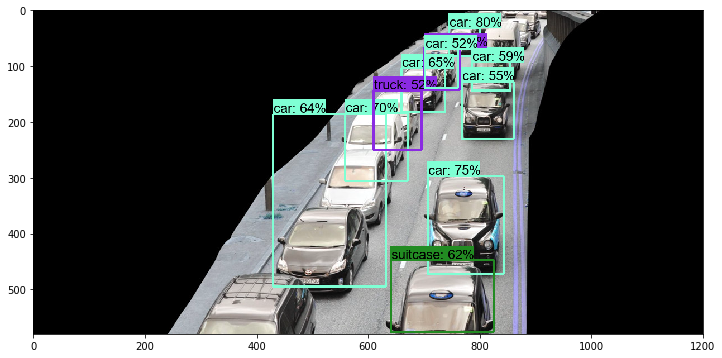

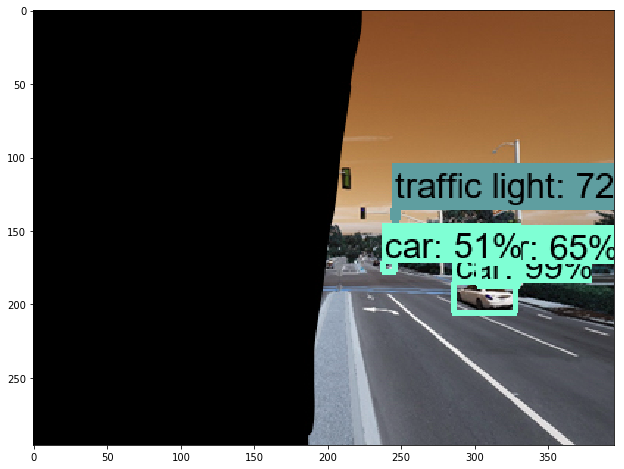

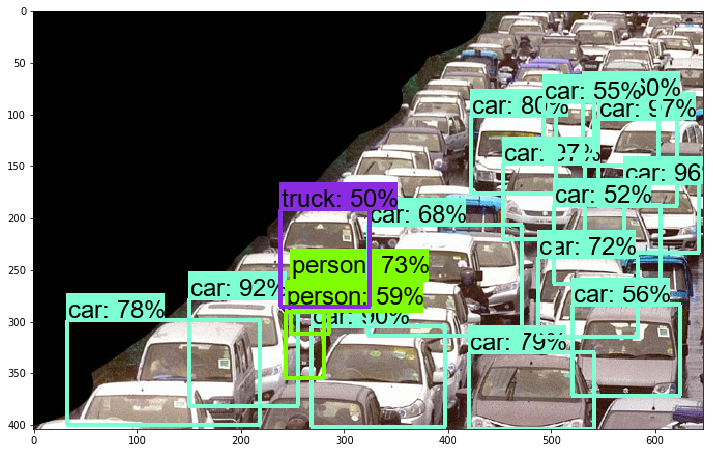

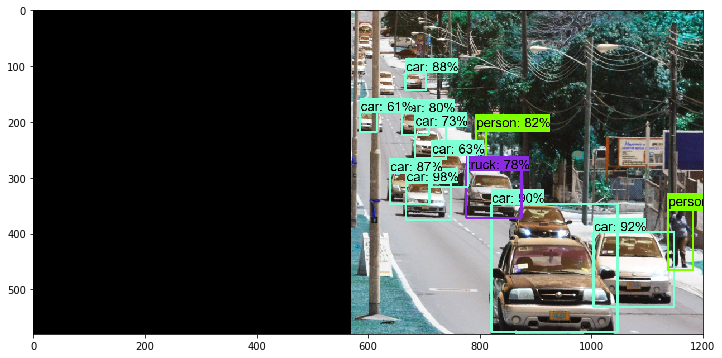

In [25]:
plt.show()